In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb

In [64]:
data = pd.read_csv('/content/AIML Dataset.csv')  # replace with your file name
print("Data Shape:", data.shape)

Data Shape: (1159457, 11)


In [65]:
print(data.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0      0.0             0.0  
1  M2044282225             0.0             0.0      0.0             0.0  
2   C553264065             0.0             0.0      1.0             0.0  
3    C38997010         21182.0             0.0      1.0             0.0  
4  M1230701703             0.0             0.0      0.0             0.0  


In [67]:
print(data.isnull().sum())  # Check for missing values

step              0
type              0
amount            1
nameOrig          1
oldbalanceOrg     1
newbalanceOrig    1
nameDest          1
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64


In [68]:
print(data['isFraud'].value_counts())  # Class distribution

isFraud
0.0    1157948
1.0       1508
Name: count, dtype: int64


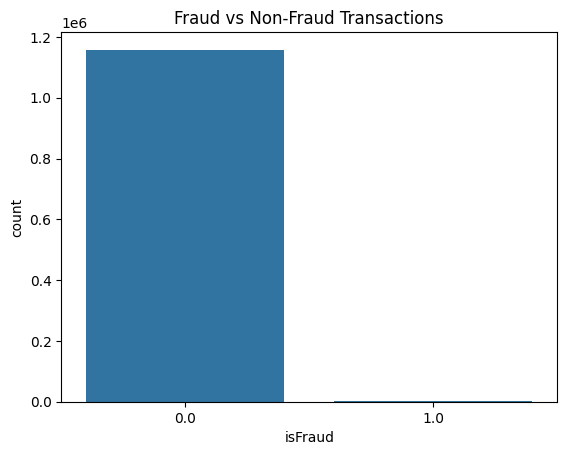

In [69]:
sns.countplot(x='isFraud', data=data)
plt.title('Fraud vs Non-Fraud Transactions')
plt.show()

In [70]:
data = pd.get_dummies(data, columns=['type'], drop_first=True)

In [71]:
features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'] + \
           [c for c in data.columns if 'type_' in c]
X = data[features]
y = data['isFraud']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [74]:
num_cols = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [76]:
print(y_train.isnull().sum())


1


In [78]:
# Keep only rows where y_train is not NaN
not_null_index = y_train[y_train.notnull()].index
X_train = X_train.loc[not_null_index]
y_train = y_train.loc[not_null_index]


In [79]:
# Fill numerical NaNs with median
num_cols = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
X_train[num_cols] = X_train[num_cols].fillna(X_train[num_cols].median())

# Fill any remaining NaNs in categorical (if exists) with mode
X_train = X_train.fillna(X_train.mode().iloc[0])


In [80]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("After SMOTE:", pd.Series(y_train_res).value_counts())


After SMOTE: isFraud
0.0    926339
1.0    926339
Name: count, dtype: int64


In [81]:
X_test[num_cols] = X_test[num_cols].fillna(X_train[num_cols].median())
X_test = X_test.fillna(X_train.mode().iloc[0])


In [82]:
import xgboost as xgb

# Create XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=(len(y_train_res[y_train_res==0])/len(y_train_res[y_train_res==1])),
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the model
model.fit(X_train_res, y_train_res)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:39:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [83]:
# Predict on test set
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:,1]  # probabilities for ROC-AUC


Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    231609
         1.0       0.09      0.97      0.16       283

    accuracy                           0.99    231892
   macro avg       0.54      0.98      0.58    231892
weighted avg       1.00      0.99      0.99    231892

ROC-AUC Score: 0.993442631404484


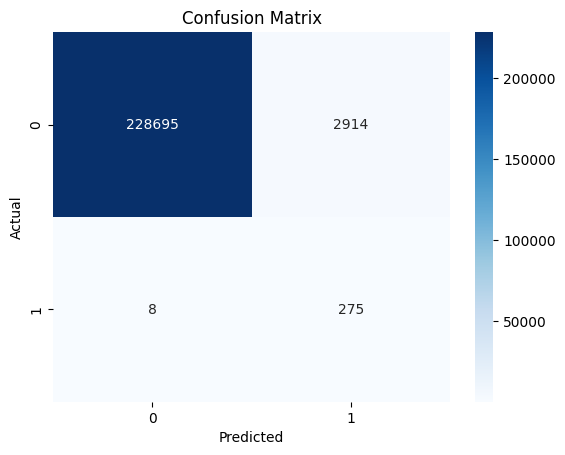

In [84]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC-AUC score
roc_score = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC Score:", roc_score)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


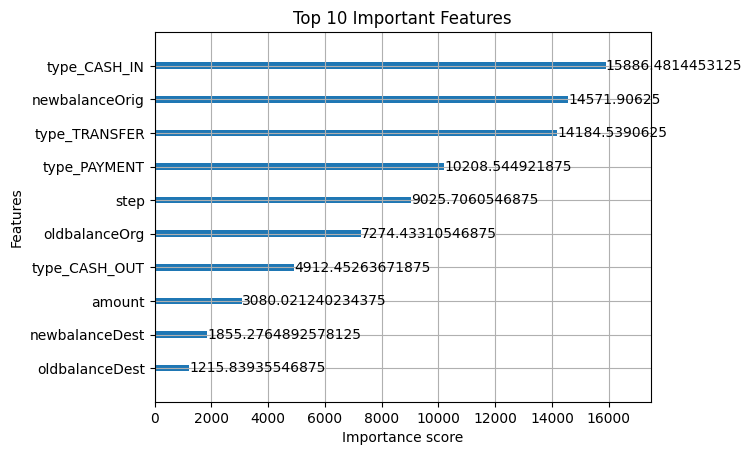

In [85]:
xgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.title('Top 10 Important Features')
plt.show()

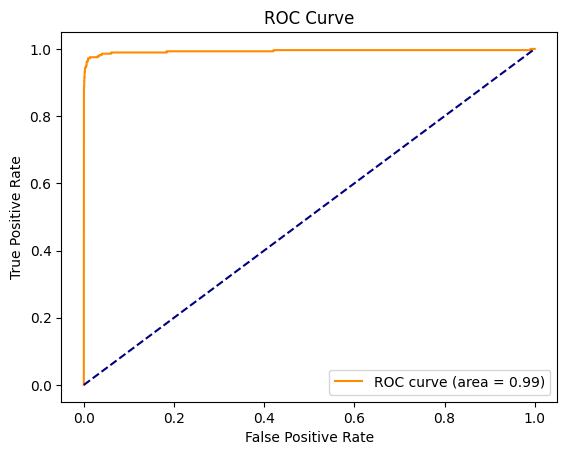

In [86]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()